In [578]:
from datetime import datetime
import datetime as dt
import time
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import IPython as ip
import  os as os

In [343]:
sg = Subgrounds()
apiKey = input('API Key, please')

In [344]:
#for when we save the files
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".

*******************************************************************
*******************************************************************
LET'S LOOK AT SILO BORROWS FIRST

In [592]:
#SILO subgraph: https://gateway.thegraph.com/api/[api-key]/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB
silo = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB')

##this captures the list of people who borrowed XAI against gOHM
borrows = silo.Query.borrows(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #skip = skipValue,
    where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' }

)

borrowsDb = sg.query_df([
    borrows.id
    ,borrows.hash
    ,borrows.logIndex
    ,borrows.blockNumber
    ,borrows.timestamp
    ,borrows.account
    ,borrows.market
    ,borrows.market.rates
    ,borrows.asset
    ,borrows.amount
    ,borrows.amountUSD 
])
borrowsDb.head(100)

#this, in turn, pulls repayment events
repays = silo.Query.repays(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #skip = skipValue,
    where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' }

)

repaysDb = sg.query_df([
    repays.id
    ,repays.hash
    ,repays.logIndex
    ,repays.blockNumber
    ,repays.timestamp
    ,repays.account
    ,repays.market
    ,repays.market.rates
    ,repays.asset
    ,repays.amount
    ,repays.amountUSD
    ,repays.position
])
repaysDb.head(100)

In [593]:
oldBorrowsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_borrows.csv'
try:
    oldBorrowsDb = pd.read_csv (siloFileName)
except:
    oldBorrowsDb = pd.DataFrame()
oldBorrowsDb.head(100)

""


In [594]:
maxSiloBorrowTimestamp = 0
try:
    maxSiloBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxSiloBorrowTimestamp = 0
maxSiloBorrowTimestamp = int(maxSiloBorrowTimestamp)
maxSiloBorrowTimestamp

0

In [597]:
##this captures the ENTIRE list of people who borrowed XAI against gOHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = silo.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0'
                ,'timestamp_gte': maxSiloBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  132  - latest recordID:  0xd5dc7147192591c7d19856d12e9278928932a5921653c46b467c1c979ff85aad   0xd5dc7147192591c7d19856d12e9278928932a5921653c46b467c1c979ff85aad-110  - borrows DB length:  132  - latest record from:  2023-02-14 06:07:35 0 days ago
Done. Total Records collected:  132


In [598]:
borrowsDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event
0,0xd5dc7147192591c7d19856d12e9278928932a5921653...,0xd5dc7147192591c7d19856d12e9278928932a5921653...,16627480,1676383655,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,992.079025,borrow
1,0xd5dc7147192591c7d19856d12e9278928932a5921653...,0xd5dc7147192591c7d19856d12e9278928932a5921653...,16627480,1676383655,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,992.079025,borrow
2,0xd5dc7147192591c7d19856d12e9278928932a5921653...,0xd5dc7147192591c7d19856d12e9278928932a5921653...,16627480,1676383655,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,992.079025,borrow
3,0xd5dc7147192591c7d19856d12e9278928932a5921653...,0xd5dc7147192591c7d19856d12e9278928932a5921653...,16627480,1676383655,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,992.079025,borrow
4,0xd5dc7147192591c7d19856d12e9278928932a5921653...,0xd5dc7147192591c7d19856d12e9278928932a5921653...,16627480,1676383655,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,None,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,992.079025,borrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,16505284,1674908519,0x42daeb9ca091e3933c8ee93c029701b926b1f336,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102213,None,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,10000000000000000000000,10040.961438,borrow
96,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,16204982,1671286919,0x44504ba8d43b30e882503948654e247b928bcc7f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,500000000000000000000,498.489611,borrow
97,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,16204982,1671286919,0x44504ba8d43b30e882503948654e247b928bcc7f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,500000000000000000000,498.489611,borrow
98,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,0xc629960194d24bb2e3aaf7a91b2cf4f547703cd7ed68...,16204982,1671286919,0x44504ba8d43b30e882503948654e247b928bcc7f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,None,BORROW

In [599]:
#I swear I will figure out synthetic fields, but until then...
borrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From borrowsDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x97811f7e7b7d202797093d44047ed986054be3dd6120...,0x97811f7e7b7d202797093d44047ed986054be3dd6120...,16623063,1676330255,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102213,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,2457516074488804244751,2446.717700,borrow,2023-02-13 23:17:35
96,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,16588637,1675914791,0x804157889ac56a4e50278610c67960c1605a3264,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,1005.010529,borrow,2023-02-09 03:53:11
97,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,16588637,1675914791,0x804157889ac56a4e50278610c67960c1605a3264,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,1005.010529,borrow,2023-02-09 03:53:11
98,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a

In [600]:
borrowsDbTimed = pd.concat([oldBorrowsDb,borrowsDbTimed]).drop_duplicates().reset_index(drop=True)
borrowsDbTimed.drop_duplicates()
borrowsDbTimed = db.query("select "
               "    * "
               "From borrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.347562,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.631787,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x97811f7e7b7d202797093d44047ed986054be3dd6120...,0x97811f7e7b7d202797093d44047ed986054be3dd6120...,16623063,1676330255,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.102213,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.000165,2457516074488804244751,2446.717700,borrow,2023-02-13 23:17:35
96,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,16588637,1675914791,0x804157889ac56a4e50278610c67960c1605a3264,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,1005.010529,borrow,2023-02-09 03:53:11
97,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,16588637,1675914791,0x804157889ac56a4e50278610c67960c1605a3264,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.278084,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.000165,1000000000000000000000,1005.010529,borrow,2023-02-09 03:53:11
98,0x2c0d9ab92c0eef11fa3394b4a89a62c7ee27bd5b64a1...,0x2c0d9ab92c0eef11fa3394b4a

Why the heck do I see several interest rates for the same txn?

In [601]:
path =file+'/siloFinance_borrows.csv'
borrowsDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_borrows_piped.csv'
borrowsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


********************************************************************
********************************************************************
VESTA BORROWS

In [602]:
#https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance
vesta = sg.load_api('https://api.thegraph.com/subgraphs/name/shinitakunai/vestafinance-v1_2')

In [603]:
oldVestaBorrowsDb = pd.DataFrame()
siloFileName = file+'/vesta_borrow_events.csv'
try:
    oldVestaBorrowsDb = pd.read_csv (siloFileName)
except:
    oldVestaBorrowsDb = pd.DataFrame()
oldVestaBorrowsDb.head(100)

""


In [613]:
maxVestaBorrowTimestamp = 0
try:
    maxVestaTroveChangeId = (max(0,oldVestaBorrowsDb['troveChanges_id'].max()))
    maxVestaTroveChangeId = int(maxVestaTroveChangeId)
    vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
                ,'id_gte': maxVestaTroveChangeId
         }
        )
    vestaBorrowslist = sg.query_df([
            vestaBorrows.id
            ,vestaBorrows.transaction.id
            ,vestaBorrows.transaction.blockNumber
            ,vestaBorrows.debtChange
            ,vestaBorrows.transaction.timestamp
            ,vestaBorrows.trove.owner.id
            ,vestaBorrows.trove.asset.id
            ,vestaBorrows.trove.asset.name
        ])
except:
    maxVestaTroveChangeId = 0
    vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
               #,'id_gte': maxVestaTroveChangeId
         }
    )
    vestaBorrowslist = sg.query_df([
            vestaBorrows.id
            ,vestaBorrows.transaction.id
            ,vestaBorrows.transaction.blockNumber
            ,vestaBorrows.debtChange
            ,vestaBorrows.transaction.timestamp
            ,vestaBorrows.trove.owner.id
            ,vestaBorrows.trove.asset.id
            ,vestaBorrows.trove.asset.name
        ])

vestaBorrowslist.head(10)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name
0,99981,0xf935941fd9f2518fa2a5f5f8d29dfa38c92fccb25b75...,34713629,-0.100000,1667397544,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
1,99820,0x467b6aa4a3f3d45e9316a143c45bf91c83ed1f662a4b...,34701032,-0.010000,1667393421,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
2,9972,0xfd781bb00f9e6d9599ce7aebda95979bfb902d3d73d2...,11845437,-2848.848834,1652313237,0x0c20e9958e4eb2d9c112d1469e17ab6c830cde09,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
3,99669,0xe104d6896bf784009bd9aa410f077f9c0a25154ab628...,34691865,-0.100000,1667390188,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
4,9962,0x2fde74916c909648c83e2725fecdc902181371a58c1f...,11842359,-700.000000,1652309981,0xe9f6711b7c92581856e0419399bc4fb9c36ec7e3,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
5,9961,0x1ebcd76a95f023492880bf7f7fbf3183e2197dd266a2...,11841593,-156.000000,1652309386,0x20fd6151bb6c78c6b5c89859bd5076dd852cc461,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
6,99531,0xc4558983947cedeace28d691cf9a70d871256ccd9021...,34681251,-0.020000,1667386332,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
7,9924,0x6a478fd975875045387ad810583e8270a25530599a6d...,11835231,-4000.003949,1652304099,0x6688b44ff874e246c441397d60fc169d4972a1ab,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
8,99043,0x24f693681f80f12946d463995c424c41f37a01dbd227...,34647273,-31300.004280,1667374762,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM
9,9896,0xdf29dc3054d53c0c8681ba1e5a9ab72d0dafbcf77de4...,11831764,-222.000000,1652301736,0x7ff15d6cf1a7bf0efa7435543cf086835fc80d53,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM


vestaBorrows = vesta.Query.troveChanges(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                ,'debtChange_lt':0
                ,'id_gte': maxVestaTroveChangeId
         }
    )
vestaBorrowslist = sg.query_df([
        vestaBorrows.id
        ,vestaBorrows.transaction.id
        ,vestaBorrows.transaction.blockNumber
        ,vestaBorrows.debtChange
        ,vestaBorrows.transaction.timestamp
        ,vestaBorrows.trove.owner.id
        ,vestaBorrows.trove.asset.id
        ,vestaBorrows.trove.asset.name
    ])

vestaBorrowslist.head(10)

In [636]:
##this captures the list of people who vestaBorrowed XAI against gOHM
vestaBorrowTicker = 0
vestaBorrowslist = pd.DataFrame()
vestaBorrowsDb = pd.DataFrame()
vestaBorrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaBorrowTicker)*(1000)
    try:
        maxVestaTroveChangeId = (max(0,oldVestaBorrowsDb['troveChanges_id'].max()))
        maxVestaTroveChangeId = int(maxVestaTroveChangeId)
        vestaBorrows = vesta.Query.troveChanges(
            orderBy='id',
            orderDirection='desc',
            first=1000,
            skip = skipValue,
            where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                    ,'debtChange_gt':0
                    ,'id_gte': maxVestaTroveChangeId
             }
            )
        vestaBorrowslist = sg.query_df([
                vestaBorrows.id
                ,vestaBorrows.transaction.id
                ,vestaBorrows.transaction.blockNumber
                ,vestaBorrows.debtChange
                ,vestaBorrows.transaction.timestamp
                ,vestaBorrows.trove.owner.id
                ,vestaBorrows.trove.asset.id
                ,vestaBorrows.trove.asset.name
            ])
    except:
        maxVestaTroveChangeId = 0
        vestaBorrows = vesta.Query.troveChanges(
            orderBy='id',
            orderDirection='desc',
            first=1000,
            skip = skipValue,
            where= { 'asset': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1'  #gOHM market
                    ,'debtChange_gt':0
                   #,'id_gte': maxVestaTroveChangeId
             }
        )
        vestaBorrowslist = sg.query_df([
                vestaBorrows.id
                ,vestaBorrows.transaction.id
                ,vestaBorrows.transaction.blockNumber
                ,vestaBorrows.debtChange
                ,vestaBorrows.transaction.timestamp
                ,vestaBorrows.trove.owner.id
                ,vestaBorrows.trove.asset.id
                ,vestaBorrows.trove.asset.name
            ])

    #vestaBorrowslist.sort_values(by=['vestaBorrows_timestamp'])

    vestaBorrowsDb=pd.concat([vestaBorrowsDb, vestaBorrowslist])
    recordTimestamp1 = vestaBorrowsDb.iat[vestaBorrowTicker,4]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaBorrowsDbLength = len(vestaBorrowsDb)
    vestaBorrowListLength = len(vestaBorrowslist)
    recordID = vestaBorrowsDb.iat[vestaBorrowTicker,0]
    vestaBorrow = vestaBorrowsDb.iat[vestaBorrowTicker,1]
    print("iterations: ", vestaBorrowTicker, "Lines skipped: ",skipValue, "records collected: ", vestaBorrowListLength, " - latest recordID: ",vestaBorrow, " ", recordID , " - vestaBorrows DB length: ", vestaBorrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaBorrowTicker, "records collected: ", vestaBorrowListLength, " - userdb length: ", vestaBorrowsDbLength)
    vestaBorrowTicker = vestaBorrowTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaBorrowListLength<1000: exit =True

#vestaBorrowsDbTimed.columns = vestaBorrowsDbTimed.columns.str.replace("borrows", "transaction")
vestaBorrowsDb['event']='borrow'
print("Done. Total Records collected: ", vestaBorrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0x21da8f0687a20a391e7e08c8af41efd288af11da388165d1fe8423ff8468ed59   9966  - vestaBorrows DB length:  1000  - latest record from:  2022-05-11 16:41:54 279 days ago
Done. Total Records collected:  1000


In [637]:
vestaBorrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(troveChanges_transaction_timestamp::int) dateTime "
               "From vestaBorrowsDb "
                               "order by troveChanges_transaction_timestamp desc"
               ).df()

vestaBorrowsDbTimed.head(1000)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name,event,dateTime
0,206942,0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c...,60901615,0.788990,1676391255,0x29e46015ccfe13cfe8dc96d75760a6290df311ee,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 16:14:15
1,206937,0x555fa4ea5c65b2f92015f8505969c1f8b62a3d72b250...,60879995,50.250068,1676385727,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 14:42:07
2,206872,0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b...,60849806,6000.000000,1676378031,0xc1bbfbc99b57da20e5504e9960e81277d63faeea,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 12:33:51
3,206839,0xa31f8bbbd75cd4d9dd5b380cbcabe392c13b3103ff4b...,60823424,4999.907810,1676370864,0x2682efcc31de7a06ed3bf8b0be156ff88e1663a1,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 10:34:24
4,206771,0x0b6ce781cafec4a4ebbd7247a9149f944ab5ecab3091...,60666606,199.999428,1676323500,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-13 21:25:00
...,...,...,...,...,...,...,...,...,...,...
995,321,0xe7a2f919a8b75cdfda3826f235fb6fb09d7fe3a285d2...,5697588,2231.175000,1644385430,0x1cb4831b6df1d9cb07279b93a0e101db9b2295d0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:43:50
996,313,0x8a69f94169d23f37811def09cee4008e7305b538a748...,5697498,12180.000000,1644385318,0xf5b4635f3858a2bc80a17bd4450e05a35ad99a72,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:41:58
997,312,0x3cf08c9c4d3cf6c6a5bfd9bc707237a199ac0eb0559c...,5697463,333.750000,1644385225,0x87209dc4b76b14b67bc5e5e5c0737e7d002a219c,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:40:25
998,305,0x54c221378376ddc4b488cf03648bbc0a83ad6f51ca9f...,5697391,1567.755688,1644385147,0x56c6e3385acc23826ef764066fa5a5f422c78e14,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-02-09 05:39:07


In [638]:
vestaBorrowsDbTimed = pd.concat([oldVestaBorrowsDb,vestaBorrowsDbTimed]).drop_duplicates().reset_index(drop=True)
vestaBorrowsDbTimed.drop_duplicates()
vestaBorrowsDbTimed = db.query("select "
               "    * "
               "From vestaBorrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10 "
                     # "order by borrows_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaBorrowsDbTimed.head(100)

,troveChanges_id,troveChanges_transaction_id,troveChanges_transaction_blockNumber,troveChanges_debtChange,troveChanges_transaction_timestamp,troveChanges_trove_owner_id,troveChanges_trove_asset_id,troveChanges_trove_asset_name,event,dateTime
0,206942,0xf52f858917e2e47e905f9d3882ee0a59984316b6d54c...,60901615,0.788990,1676391255,0x29e46015ccfe13cfe8dc96d75760a6290df311ee,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 16:14:15
1,206937,0x555fa4ea5c65b2f92015f8505969c1f8b62a3d72b250...,60879995,50.250068,1676385727,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 14:42:07
2,206872,0x8102272a3bd5f0e2e3946fbff84f666fbec16b044b5b...,60849806,6000.000000,1676378031,0xc1bbfbc99b57da20e5504e9960e81277d63faeea,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 12:33:51
3,206839,0xa31f8bbbd75cd4d9dd5b380cbcabe392c13b3103ff4b...,60823424,4999.907810,1676370864,0x2682efcc31de7a06ed3bf8b0be156ff88e1663a1,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-14 10:34:24
4,206771,0x0b6ce781cafec4a4ebbd7247a9149f944ab5ecab3091...,60666606,199.999428,1676323500,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2023-02-13 21:25:00
...,...,...,...,...,...,...,...,...,...,...
95,164364,0x1e76319ba34fe10f7657200c58b294bd7eb66c827d71...,48782238,5853.449258,1671981254,0xded5d8c6b271a48f3b9ba20e8aa761a6baa2fac9,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-12-25 15:14:14
96,164321,0x194e2bb92ce2f2cb168458102d1cbc79ed9bbd7757bd...,48754692,150.000118,1671973124,0xc9e166f2737e004e93800dcef0d608b014df07f6,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-12-25 12:58:44
97,163703,0x882593f140df3ff51511a47c7cb3c433e4a4c44a12c9...,48435322,2258.315533,1671865683,0xded5d8c6b271a48f3b9ba20e8aa761a6baa2fac9,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-12-24 07:08:03
98,163324,0xc502f9e5eb845a34d721e418dd597bb64e15abace157...,48288379,50047.781139,1671802945,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,gOHM,borrow,2022-12-23 13:42:25


In [639]:
path =file+'/vesta_borrow_events.csv'
vestaBorrowsDbTimed.to_csv(path, index = False)

path =file+'/vesta_borrow_events_piped.csv'
vestaBorrowsDbTimed.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(vestaBorrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\Lending\results/vesta_borrow_events_piped.csv file saved, 1000  records


************************************************************
FINE.... FRAX TOO

This subgraph is completely different, so we're going to  have to crunch in order to merge all these tables into coherent reports

In [640]:
frax = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GELTrjPJYEzxyp6Y2CtEaYpGHcJNrJA6i5Ci4KfJSEsf')

In [641]:
oldFraxBorrows = pd.DataFrame()
fraxFileName = file+'/frax_borrows.csv'
try:
    oldFraxBorrows = pd.read_csv (fraxFileName)
except:
    oldFraxBorrows = pd.DataFrame()
oldFraxBorrows.head(100)

,actions_root_address,dateTime,amountUsd,actions_token_name
0,0x03da5c3b75503a1dda58e2bd23d4726b5ee8dd26,2022-12-28 02:04:23,560968.505801,Frax
1,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-08 17:58:59,400000.000000,Frax
2,0xbf23c4820def2ed7cab808bec348f7072035a289,2022-12-16 19:03:47,376035.401417,Frax
3,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,2023-01-18 14:29:59,350000.000000,Frax
4,0x2a363fccde360dea7b0df06ed5416f925ed62ef7,2022-12-23 21:38:35,350000.000000,Frax
...,...,...,...,...
95,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-08 19:56:23,10000.000000,Frax
96,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-03 15:31:23,10000.000000,Frax
97,0x783f3cad39b6528e192722527429bbbdaad01648,2023-01-11 03:49:11,10000.000000,Frax
98,0xe4cbfee800f8cc58b79ccd22a16a279a63c480ce,2022-12-28 15:06:35,10000.000000,Frax


In [642]:
maxBorrowFraxTimestamp = 0
try:
    maxBorrowFraxTimestamp = (max(1,oldFraxBorrows['actions_timestamp'].max()))-5
except:
        maxBorrowFraxTimestamp = 0
maxBorrowFraxTimestamp = int(maxBorrowFraxTimestamp)
maxBorrowFraxTimestamp

0

In [643]:
actionListLength=0
actionTicker = 0
fraxUsersDb = pd.DataFrame()
actionsDb = pd.DataFrame()
actionListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    #listLength=0
    skipValue = (actionTicker)*(1000)
    actionsQuery = frax.Query.actions(
         orderBy='timestamp'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.actions.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52'
                 ,'timestamp_gte': maxBorrowFraxTimestamp
                 }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    actions= sg.query_df([
        actionsQuery.id
        ,actionsQuery.type
        ,actionsQuery.amount
        ,actionsQuery.timestamp
        ,actionsQuery.block
        ,actionsQuery.token.name
        ,actionsQuery.root.address
        ]
    )

    actions.sort_values(by=['actions_timestamp'])

    actionsDb=pd.concat([actionsDb, actions])
    recordTimestamp1 = actionsDb.iat[actionTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    actionsDbLength = len(actionsDb)
    actionListLength = len(actions)
    recordID = actionsDb.iat[actionTicker,0]
    action = actionsDb.iat[actionTicker,1]
    print("iterations: ", actionTicker, "Lines skipped: ",skipValue, "records collected: ", actionListLength, " - latest recordID: ",action, " ", recordID , " - actions DB length: ", actionsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", actionTicker, "records collected: ", actionListLength, " - userdb length: ", actionsDbLength)
    if daysAgo>daysLimit: exit =True
    if actionsDbLength<1000: exit =True
    actionTicker = actionTicker+1
print("Done. Total Records collected: ", actionsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  borrowAsset   0x2e322fd549b557f43eba958c0545112256bfda35d962f6d6abd4c600ac6dbe7b  - actions DB length:  1000  - latest record from:  2023-02-14 10:05:59 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  1000  - latest recordID:  addAsset   0x3da9de5c721a6eabf8576551f3d8d1adc4da3f801a68cca02cef546bbac64795  - actions DB length:  2000  - latest record from:  2023-02-14 07:02:11 0 days ago
iterations:  2 Lines skipped:  2000 records collected:  1000  - latest recordID:  borrowAsset   0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b69775010e3e42465a9921f6b+1  - actions DB length:  3000  - latest record from:  2023-02-14 06:02:47 0 days ago
iterations:  3 Lines skipped:  3000 records collected:  1000  - latest recordID:  addCollateral   0x1dfd3172c36e389c77cfd3e1d4e0ae425056986b69775010e3e42465a9921f6b  - actions DB length:  4000  - latest record from:  2023-02-14 06:02:47 0 days ago
iterations:  4 Lin

KeyboardInterrupt: 

In [ ]:
    fraxActionsDbTimed = db.query("select "
                   "    * "
                        " ,to_timestamp(actions_timestamp) dateTime "
                    ",(actions_amount::hugeint*1e-18) amountUsd "
                   "From actionsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxActionsDbTimed.head(10)

In [ ]:
fraxActionsDbTimed = pd.concat([oldFraxBorrows,fraxActionsDbTimed]).drop_duplicates().reset_index(drop=True)
fraxActionsDbTimed.sort_values(['actions_id','amountUsd'])
fraxActionsDbTimed.drop_duplicates(keep='first' )

fraxActionsDbTimed = db.query("select "
               "    * "
               "From fraxActionsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9 "
                      "order by amountUsd desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


fraxActionsDbTimed.head(100)

In [ ]:
fraxActionsDbTimedLength = len(fraxActionsDbTimed)
path =file+'/frax_borrows.csv'
fraxActionsDbTimed.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxActionsDbTimed.to_csv(path, index = False, sep='|')

print(path, 'file saved,', fraxActionsDbTimedLength,' records')

In [644]:
fraxBorrowsDb = db.query("select distinct"
                   "    actions_root_address "
                         ", dateTime "
                         ", amountUSD "
                         ", actions_token_name "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'borrowAsset'"
                         "order by 3 desc "
                   ).df()
fraxBorrowsDb.head(10)

,actions_root_address,dateTime,amountUsd,actions_token_name
0,0x03da5c3b75503a1dda58e2bd23d4726b5ee8dd26,2022-12-28 02:04:23,560968.505801,Frax
1,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-08 17:58:59,400000.000000,Frax
2,0xbf23c4820def2ed7cab808bec348f7072035a289,2022-12-16 19:03:47,376035.401417,Frax
3,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,2023-01-18 14:29:59,350000.000000,Frax
4,0x2a363fccde360dea7b0df06ed5416f925ed62ef7,2022-12-23 21:38:35,350000.000000,Frax
5,0xb0399dac8f4d4100b49b2a7b3873481114229d18,2023-01-30 18:09:59,305000.000000,Frax
6,0x1effd55a8646f7dc67c7578c20ce575cefeb1120,2023-01-23 15:28:59,300000.000000,Frax
7,0x85b44a83bca937e844bdc290284ef6b11bc015ba,2022-12-04 16:30:11,214099.334643,Frax
8,0xe27ce7decbe14d1243efe2c927d3c090963aa1d3,2022-12-26 17:15:59,200000.000000,Frax
9,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-07 22:36:59,200000.000000,Frax


In [645]:
fraxBorrowsDb.drop_duplicates
fraxBorrowsDbLength = len(fraxBorrowsDb)
path =file+'/frax_borrows.csv'
fraxBorrowsDb.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxBorrowsDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


**********************************************************
LET'S PLAY AND CRUNCH DATA - BORROWS


In [646]:
fraxBorrowedUSDDaily = db.query("select "
                   "    date_trunc('day', cast(dateTime as timestamp)) calDay "
                         ", sum(amountUSD) amountUsdBorrowed"
                         ", count(distinct actions_root_address) borrowers "
                       "From fraxBorrowsDb "
                        "Group by 1 "
                        "order by 1 "
                   ).df()


fraxBorrowedUSDDaily['protocol'] = 'Frax'
fraxBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-12-03,52108.786050,4,Frax
1,2022-12-04,345329.334643,7,Frax
2,2022-12-05,508933.348518,5,Frax
3,2022-12-06,5000.000000,1,Frax
4,2022-12-07,206250.000000,3,Frax
...,...,...,...,...
66,2023-02-10,25000.000000,1,Frax
67,2023-02-11,47500.000000,2,Frax
68,2023-02-12,26000.000000,2,Frax
69,2023-02-13,54000.000000,2,Frax


In [647]:
siloBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',cast(dateTime as timestamp)) calDay "
                            ",transaction_amountUSD::hugeint transaction_amountUSD "
                        "   ,transaction_account_id "
                       "From borrowsDbTimed "
                   ).df()
siloBorrowedUSD.head(10)

,calDay,transaction_amountUSD,transaction_account_id
0,2023-02-09,185996.0,0xb0399dac8f4d4100b49b2a7b3873481114229d18
1,2023-02-13,71911.0,0x46535cbc3fa574c32ea392d4f89c518290597072
2,2023-02-07,29884.0,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6
3,2023-02-07,24937.0,0x36125234dd6c7d0a01dcadc67e79e061d405098e
4,2023-02-07,19923.0,0x96035b45bc0d22f0ed11283a91145fb001c48370
5,2022-12-12,11929.0,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec
6,2023-01-28,10041.0,0x42daeb9ca091e3933c8ee93c029701b926b1f336
7,2022-12-13,8041.0,0x339fd7c17ce670e7821f2f2ee94ddd49771483da
8,2023-02-07,6976.0,0xb86cd2efc1f461beee8deec2c3f053ccb2781ef9
9,2023-02-07,6016.0,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99


In [648]:
siloBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From siloBorrowedUSD "
                        "Group by 1 "
                   ).df()
siloBorrowedUSDDaily['protocol'] = 'Silo'
siloBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2023-02-09,187001.0,2,Silo
1,2023-02-13,77443.0,2,Silo
2,2023-02-07,87736.0,5,Silo
3,2022-12-12,15941.0,2,Silo
4,2023-01-28,10041.0,1,Silo
5,2022-12-13,8041.0,1,Silo
6,2023-02-01,5001.0,1,Silo
7,2023-02-14,7841.0,3,Silo
8,2022-12-17,498.0,1,Silo
9,2022-11-23,661.0,2,Silo


In [649]:
vestaBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',cast(dateTime as timestamp)) calDay "
                            ",troveChanges_debtChange::hugeint troveChanges_debtChange "
                        "   ,troveChanges_trove_owner_id  "
                       "From vestaBorrowsDbTimed "
                   ).df()

In [650]:
vestaBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(troveChanges_debtChange) amountUsdBorrowed "
                        "   ,count(distinct troveChanges_trove_owner_id) borrowers "
                       "From vestaBorrowedUSD "
                        "Group by 1 "
                   ).df()
vestaBorrowedUSDDaily['protocol'] = 'Vesta'
vestaBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2023-02-14,11051.0,4,Vesta
1,2023-02-13,500.0,2,Vesta
2,2023-02-12,91777.0,1,Vesta
3,2023-02-11,7615.0,2,Vesta
4,2023-02-10,261.0,1,Vesta
...,...,...,...,...
95,2022-09-26,10413.0,2,Vesta
96,2022-09-25,3576.0,2,Vesta
97,2022-09-24,2227.0,2,Vesta
98,2022-09-23,1921.0,3,Vesta


In [651]:
#Don't judge if I use pandas for some things and SQL for others. I'm a noob :P
dailyUsdBorrowdDb =  pd.concat([vestaBorrowedUSDDaily, siloBorrowedUSDDaily,fraxBorrowedUSDDaily])
dailyUsdBorrowdDb.head(400)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2023-02-14,11051.0,4,Vesta
1,2023-02-13,500.0,2,Vesta
2,2023-02-12,91777.0,1,Vesta
3,2023-02-11,7615.0,2,Vesta
4,2023-02-10,261.0,1,Vesta
...,...,...,...,...
66,2023-02-10,25000.0,1,Frax
67,2023-02-11,47500.0,2,Frax
68,2023-02-12,26000.0,2,Frax
69,2023-02-13,54000.0,2,Frax


In [656]:
dailyUsdBorrowdDbLength = len(dailyUsdBorrowdDb)
path =file+'/dailyUsdBorrowed.csv'
dailyUsdBorrowdDb.to_csv(path, index = False)

path =file+'/dailyUsdBorrowed_piped.csv'
dailyUsdBorrowdDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [657]:
dailyUsdBorrowdDbLength

315

[Text(0.5, 1.0, 'Borrowed per day'), Text(0.5, 0, 'protocol'), Text(0, 0.5, 'USD')]


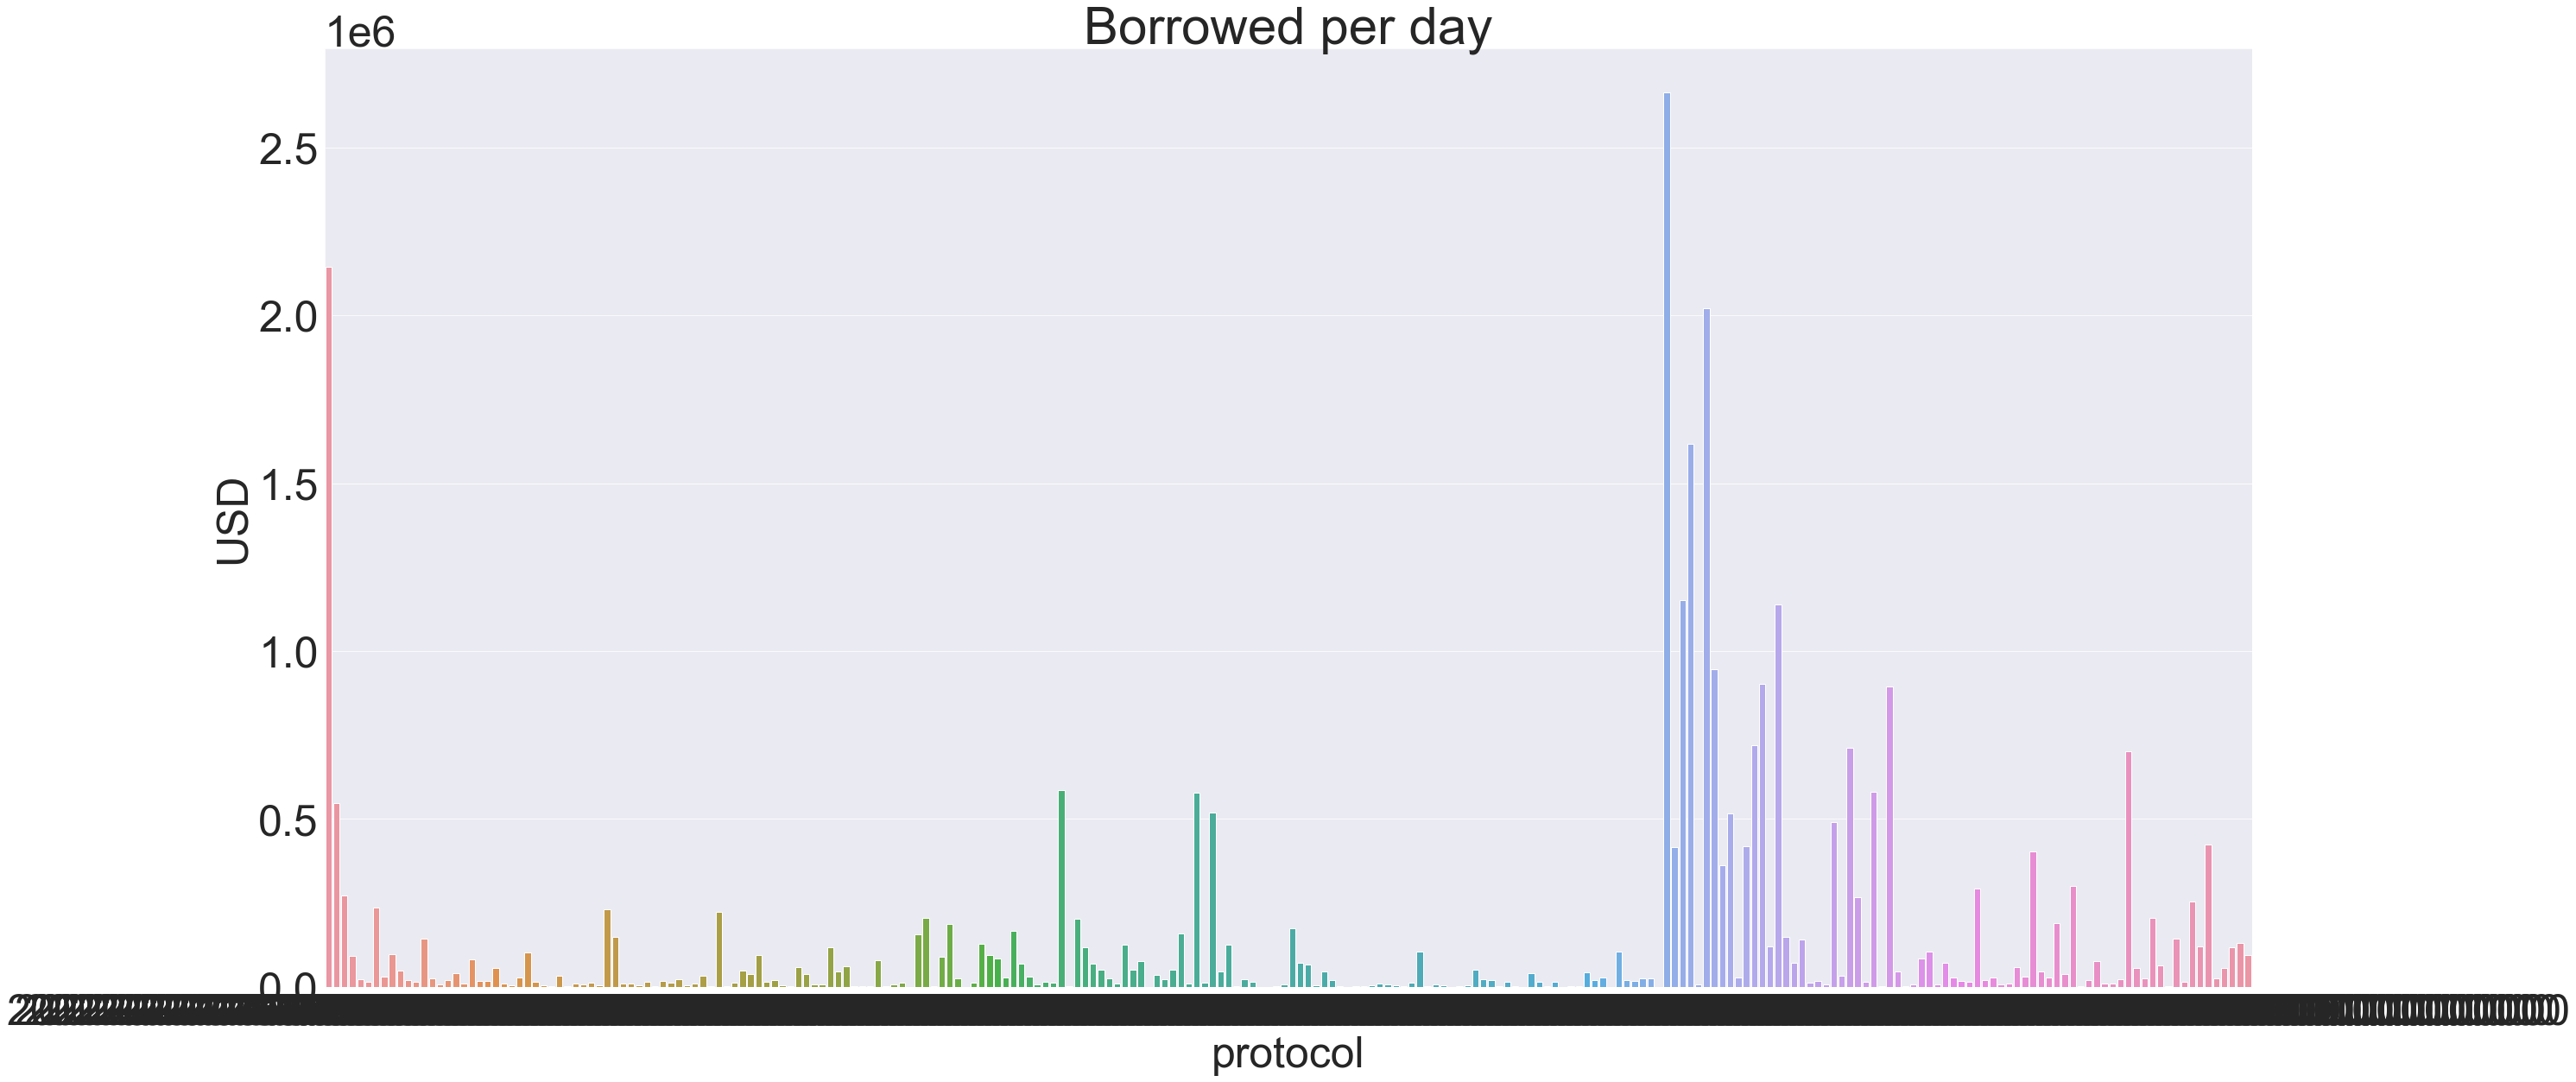

In [654]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = dailyUsdBorrowdDb.groupby("calDay")["amountUsdBorrowed"].agg("sum").reset_index()
plot_title = 'Borrowed per day'
chart=sns.barplot(data=value_locked,y="amountUsdBorrowed",x="calDay").set(title = plot_title, xlabel = 'protocol', ylabel = 'USD', )
print(chart)

[Text(0.5, 1.0, 'Borrowed per protocol'), Text(0.5, 0, 'protocol'), Text(0, 0.5, 'USD')]


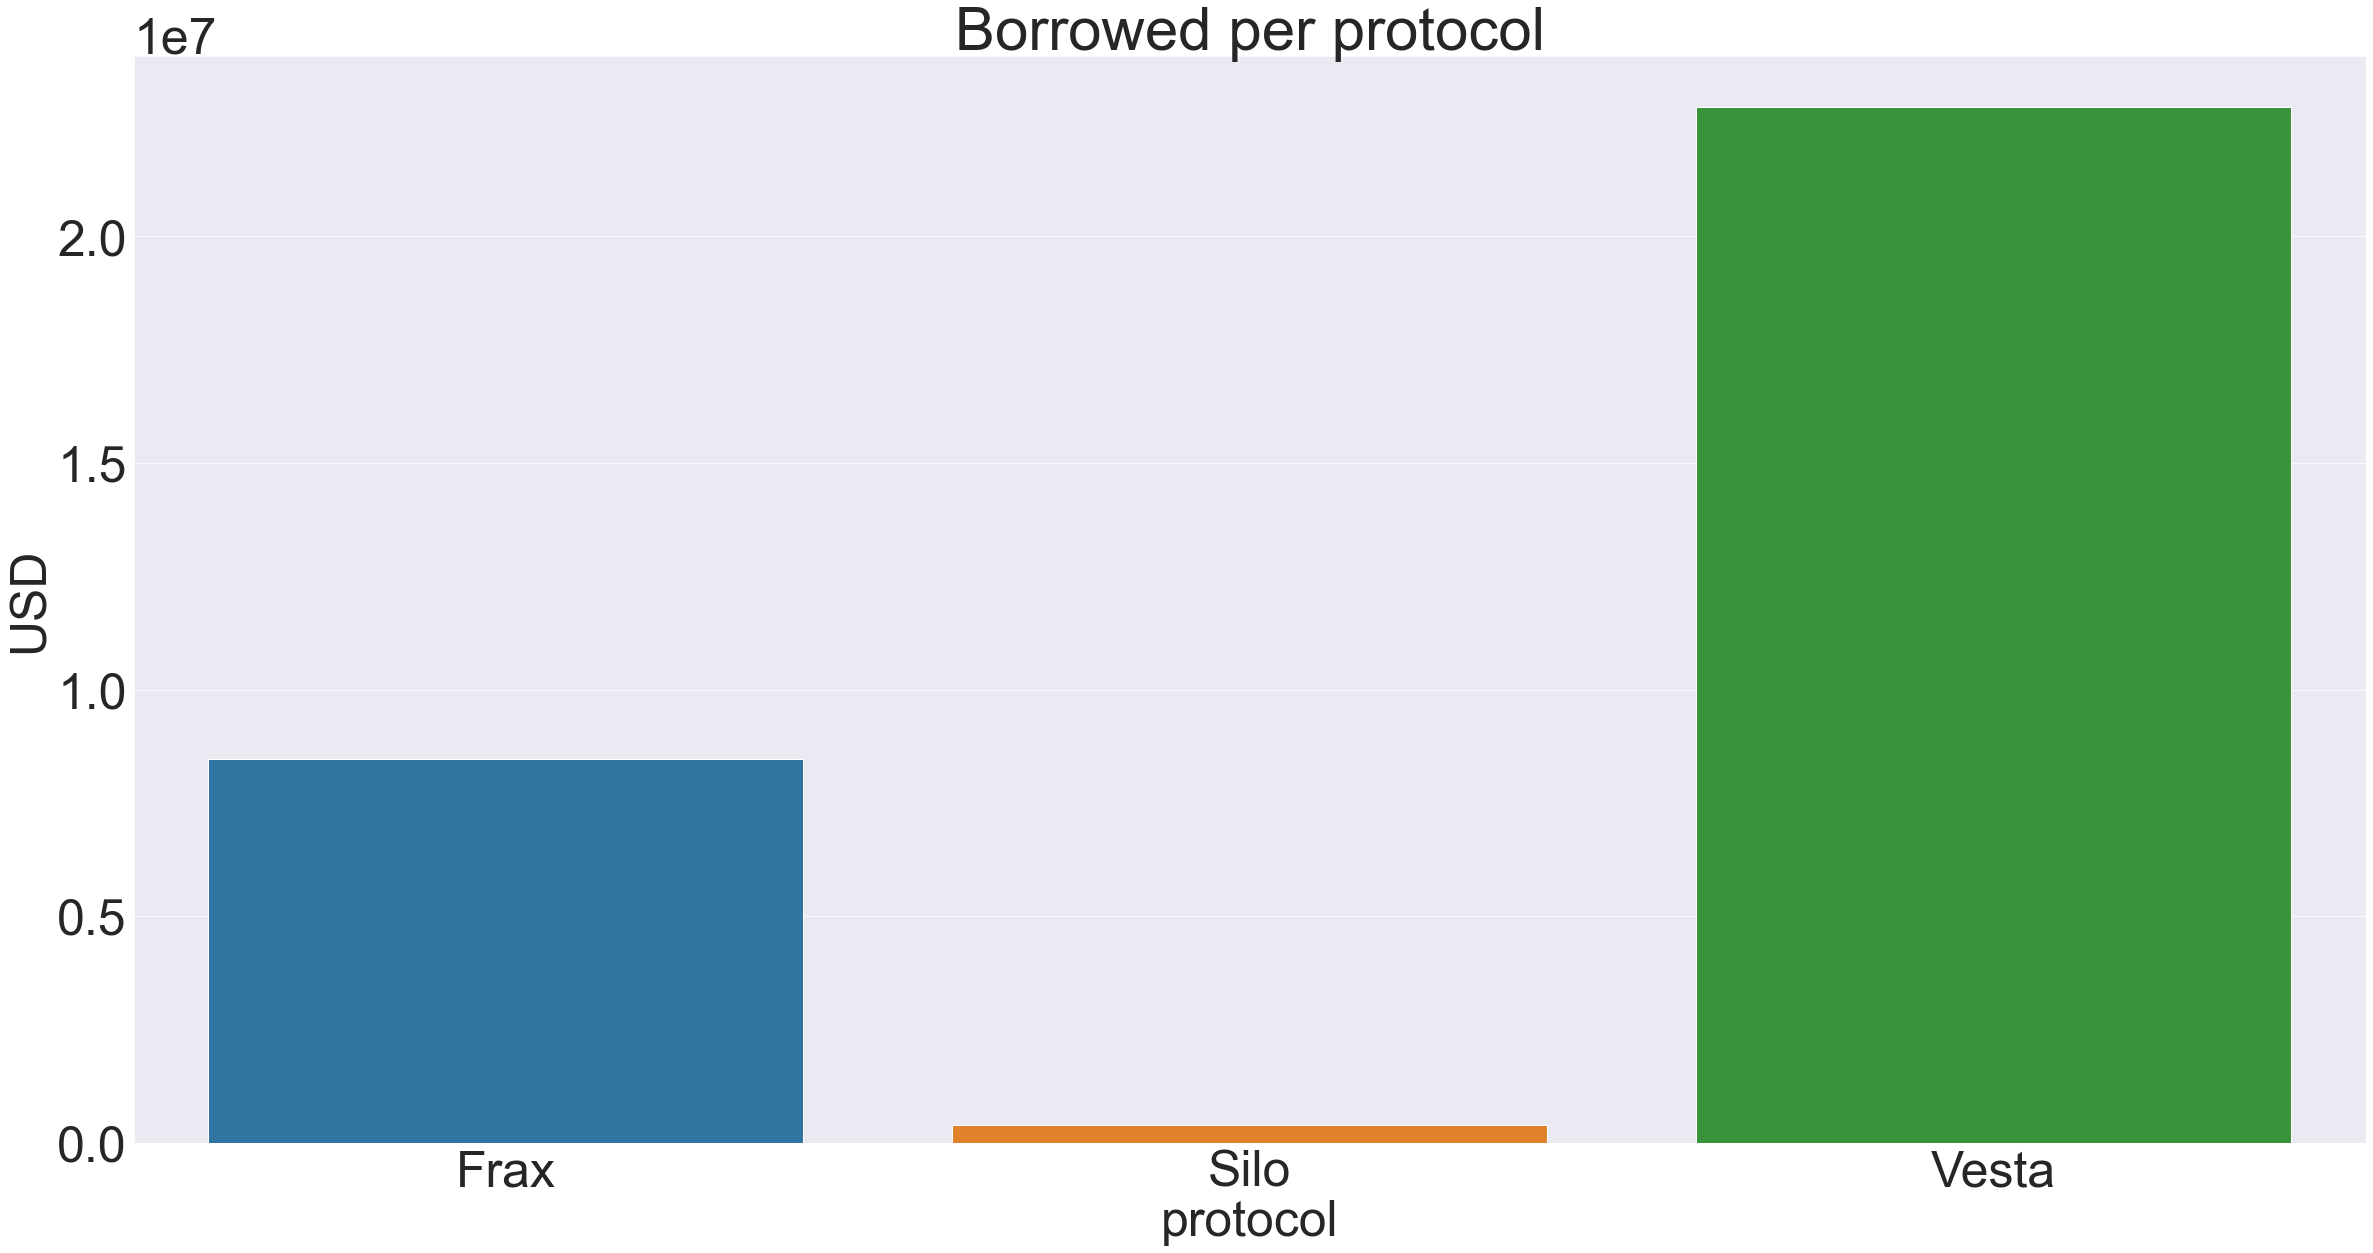

In [658]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = dailyUsdBorrowdDb.groupby("protocol")["amountUsdBorrowed"].agg("sum").reset_index()
plot_title = 'Borrowed per protocol'
chart=sns.barplot(data=value_locked,y="amountUsdBorrowed",x="protocol").set(title = plot_title, xlabel = 'protocol', ylabel = 'USD', )
print(chart)